In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [32]:
class PDE:
    def __init__(self, xi, tpoints=201, xpoints=512, trange=(0,20), xrange=(-30, 30), seed=0):
        """
        xi is a 2d matrix where each entry corresponds to a coefficient of a term, 
        where the 1st axis corresponds to the order of the space partial derivative
        and the 2nd axis corresponds to the degree of the function.
        For example, ut = 1+2u+3u**2 + 4ux+5uxu+6uxu**2 + 7uxx+8uxxu+9uxxu**2
        becomes [[1, 2, 3],[4, 5, 6],[7, 8, 9]]
        """
        
        self.rng = np.random.RandomState(seed)
        
        self.xi = xi
        self.max_order = self.xi.shape[0]-1 #the minus 1 is because it goes from 0 to max, inclusive
        self.max_degree = self.xi.shape[1]-1 #the minus 1 is because it goes from 0 to max, inclusive
        
        self.tpoints = tpoints
        self.xpoints = xpoints
        self.trange = trange
        self.xrange = xrange
        
        self.dt = (self.trange[1]-self.trange[0])/ self.tpoints #time steps
        self.dx = (self.xrange[1]-self.xrange[0])/ self.xpoints #space step
        
        self.u = self.init_u()
        self.simulated = False
        
    def init_u(self):
        #makes one wavelength of cos, from 1 crest to the next
        xarr = np.linspace(self.xrange[0], self.xrange[1], self.xpoints, endpoint=False)
        #k = 2*np.pi/(self.xrange[1] - self.xrange[0])
        #phi = np.pi
        #u0 = np.cos(k*xarr+phi)
        c = 1
        a = 0
        t = 0
        u0 = -0.5*c*1/np.cosh( 0.5*np.sqrt(c)*(xarr-c*t-a) )**2
        uempty = np.full((self.xpoints,), np.nan, dtype=float)
        return np.vstack([u0]+[uempty]*(self.tpoints-1))
    
    def __str__(self):
        rep = 'ut ='
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                if coef == 0:
                    term = ''
                else:
                    #coefficient factor
                    if coef > 0:
                        term = ' + ' + str(coef)
                    elif coef < 0:
                        term = ' - ' + str(-coef)
                    #partial deriv factor
                    if order > 0:
                        term += 'u' + 'x'*order
                    else: 
                        pass
                    #function factor
                    if degree == 1:
                        term += 'u'
                    elif degree > 1:
                        term += 'u**'+degree
                    else: 
                        pass
                rep += term
        if rep == 'ut =':
            rep = 'ut = 0'
        return rep
    def __repr__(self):
        rep = self.__str__()
        rep += '\n\twith xpoints='+str(self.xpoints)+' in '+str(self.xrange)
        rep += '\n\tand with tpoints='+str(self.tpoints)+' in '+str(self.trange)
        return rep
        
        
    def get_dxs(self, point, npoints_behind, npoints_ahead):
        diffs_behind = list(self.dxs[point-npoints_behind:point])
        diffs_ahead = list(self.dxs[point:point+npoints_ahead])
        return diffs_behind + diffs_ahead
    
    def get_du_x(self, time, point):
        ugrid = self.u[time]
        try:
            uright = ugrid[point+1]
        except IndexError:
            uright = ugrid[point+1-self.xpoints]
        try:
            uleft = ugrid[point]
        except IndexError:
            uleft = ugrid[point-self.xpoints]
        return uright - uleft
    def get_du_x_middle(self, time, point):
        ugrid = self.u[time]
        try:
            uright = ugrid[point+1]
        except IndexError:
            uright = ugrid[point+1-self.xpoints]
        try:
            uleft = ugrid[point-1]
        except IndexError:
            uleft = ugrid[point-1-self.xpoints]
        return uright - uleft
    
    def get_x_deriv_forward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point)
        else:
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point, order-1))/self.dx
    def get_x_deriv_backward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point-1)
        else:
            return (self.get_x_deriv(time, point, order-1)-self.get_x_deriv(time, point-1, order-1))/self.dx
    def get_x_deriv_middle(self, time, point, order, verbose=False):
        if order == 0:
            ugrid = self.u[time]
            return self.get_du_x_middle(time, point)/(2*self.dx)
        else: 
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point-1, order-1))/(2*self.dx)
    def get_x_deriv(self, time, point, order):
        if order > 0:
            deriv = self.get_x_deriv_middle(time, point, order)
        elif order == 0:
            try:
                deriv = self.u[time, point]
            except IndexError:
                deriv = self.u[time, point-self.xpoints]
        else:
            raise ValueError("Derivative order cannot be negative")
        return deriv
    def get_x_derivs_grid(self, time, deg=10, extra_fact=0.5):
        #deg controls the degree of the fitted polynomial
        #extra_fact controls how much to look ahead and behind the defined interval, since the interval is periodic
        #extra should not be more than half, 
        #    as that would make the fit take into account more than twice the number of points necessary
        assert extra_fact <= 0.5, "Extra should not be more than half the number of points"
        extra = int(self.xpoints*extra_fact)
        derivs = np.empty((self.max_order+1, self.xpoints))
        if self.max_order < 0:
            raise ValueError("Derivative order cannot be negative")
        else:
            derivs[0] = self.u[time]
            if self.max_order > 0:
                #smoothing
                #creating array of x values
                rangesize = self.xrange[1]-self.xrange[0]
                limleft = self.xrange[0]-rangesize
                limright = self.xrange[1]+rangesize
                xarrleft = np.linspace(limleft, self.xrange[0], self.xpoints, endpoint=False)
                xarrmid = np.linspace(self.xrange[0], self.xrange[1], self.xpoints, endpoint=False)
                xarrright = np.linspace(self.xrange[1], limright, self.xpoints, endpoint=False)
                xarr = np.hstack([xarrleft[-extra:], xarrmid, xarrright[:extra]])
                #creating array of u values
                uarr = np.hstack([self.u[time, -extra:], self.u[time], self.u[time, :extra]])
                #fitting polynomial
                #poly = np.polynomial.chebyshev.Chebyshev.fit(xarr, uarr, deg)
                poly = np.polynomial.polynomial.Polynomial.fit(xarr, uarr, deg)
                for order in range(1, self.max_order+1):
                    deriv = poly.deriv(order)
                    derivs[order] = deriv(xarrmid)
        return derivs
    def get_t_deriv(self, time, point, verbose=False):
        deriv = 0
        if verbose==True:
            print("time = "+str(time))
            print("ut = 0")
        for order in range(0, self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                u = self.u[time, point]
                if order == 0:
                    xderiv = 1
                    xderiv_str = " * 1"
                else:
                    xderiv = self.get_x_deriv(time, point, order)
                    xderiv_str = " * u"+("x"*order)
                try: 
                    deriv += coef * u**degree * xderiv
                    if verbose:
                        print("ut += "+str(coef)+xderiv_str+" * u**"+str(degree))
                except FloatingPointError:
                    #print("time = "+str(time))
                    #print("coef = "+str(coef))
                    #print("u = "+str(u))
                    #print("u**"+str(degree)+" = "+str(u**degree))
                    #print("ux = "+str(xderiv))
                    raise
        if verbose: 
            print("---------")
        return deriv
    def get_t_deriv_grid(self, time):
        t_deriv_grid = np.zeros((self.xpoints,))
        for order in range(0, self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                u_grid = self.u[time]
                x_derivs_grid = self.get_x_derivs_grid(time)
                if order == 0:
                    x_deriv_grid = np.ones((self.xpoints,))
                else:
                    x_deriv_grid = x_derivs_grid[order]
                try: t_deriv_grid += coef * u_grid**degree * x_deriv_grid
                except FloatingPointError:
                    raise
        return t_deriv_grid
    
    def sim_next_point(self, time, point):
        u_curr = self.u[time, point]
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                u_next = u_curr + self.dt*self.get_t_deriv(time, point)

        return u_next
    def sim_next_grid(self, time):
        return self.u[time] + self.get_t_deriv_grid(time) * self.dt
    def sim(self, force=False):
        if self.simulated == False or force == True:
            if force == True: print("Resimulating PDE from initial conditions")
            for time in range(self.tpoints-1):
                self.u[time+1] = self.sim_next_grid(time)
            self.simulated == True
            return self.u
        else:
            print("PDE already simulated")
            return self.u

In [33]:
xi = np.zeros((4, 2))
xi[3, 0] = -1
xi[1, 1] = 6
pde = PDE(xi, xrange=(-4, 4))
pde.sim()
print(repr(pde))

C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:203: RuntimeWarning: overflow encountered in multiply
C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:203: RuntimeWarning: invalid value encountered in multiply


ut = + 6.0uxu - 1.0uxxx
	with xpoints=512 in (-4, 4)
	and with tpoints=201 in (0, 20)


C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:203: RuntimeWarning: overflow encountered in multiply
C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:120: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:203: RuntimeWarning: invalid value encountered in multiply


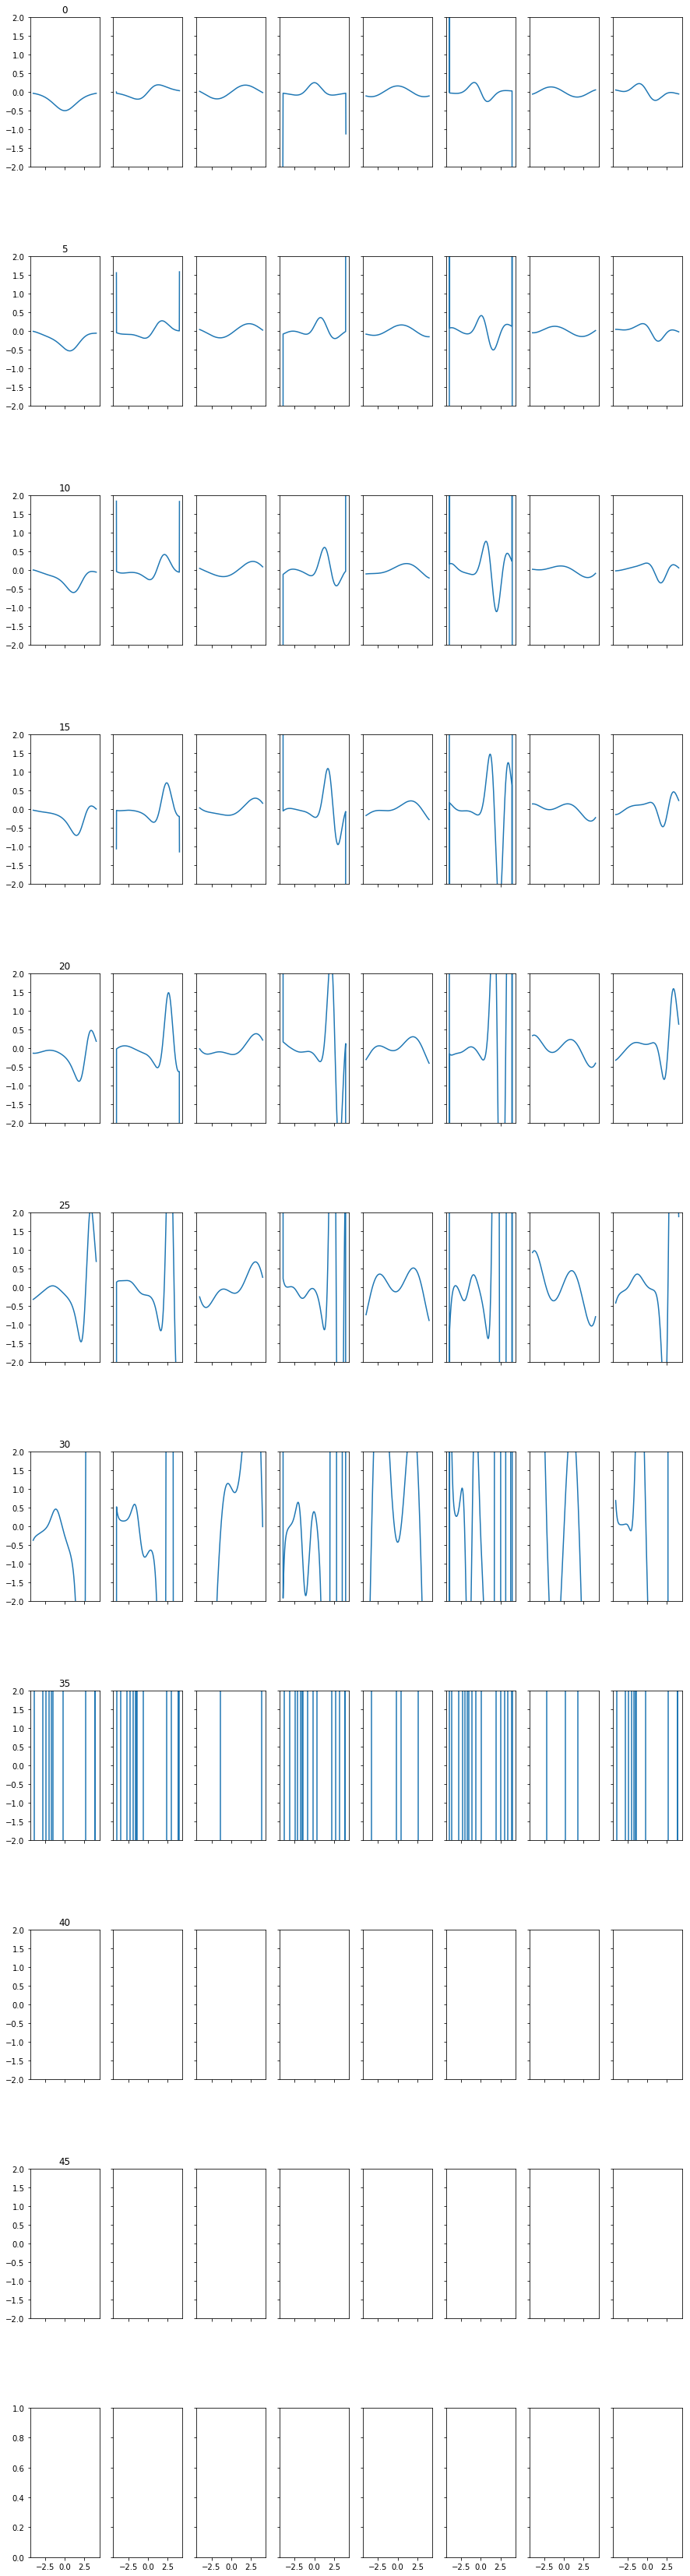

In [35]:
max_time = pde.tpoints//4
jump_fact = 5

fig, axes = plt.subplots(nrows=max_time//jump_fact+1, ncols=1+2*pde.max_order+1, figsize=(15,60), sharex=True, sharey='row')
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    if time % jump_fact == 0:
        y0 = pde.u[time]
        axes[time//jump_fact, 0].plot(x, y0)
        axes[time//jump_fact, 0].set_title(str(time))
        smooth_derivs = pde.get_x_derivs_grid(time, deg=10)#deg=pde.xpoints//10)
        for order in range(1, pde.max_order+1):
            yi_1 = [pde.get_x_deriv(time, point, order) for point in range(pde.xpoints)]
            yi_2 = smooth_derivs[order]
            axes[time//jump_fact, 2*order-1].plot(x, yi_1)
            axes[time//jump_fact, 2*order].plot(x, yi_2)
        yn = pde.get_t_deriv_grid(time)
        axes[time//jump_fact, -1].plot(x, yn)
    ylim = axes[time//jump_fact, 0].get_ylim()
    axes[time//jump_fact, 0].set_ylim(-2, 2)
        
    if time != max_time-1:
        pde.u[time+1] = pde.sim_next_grid(time)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

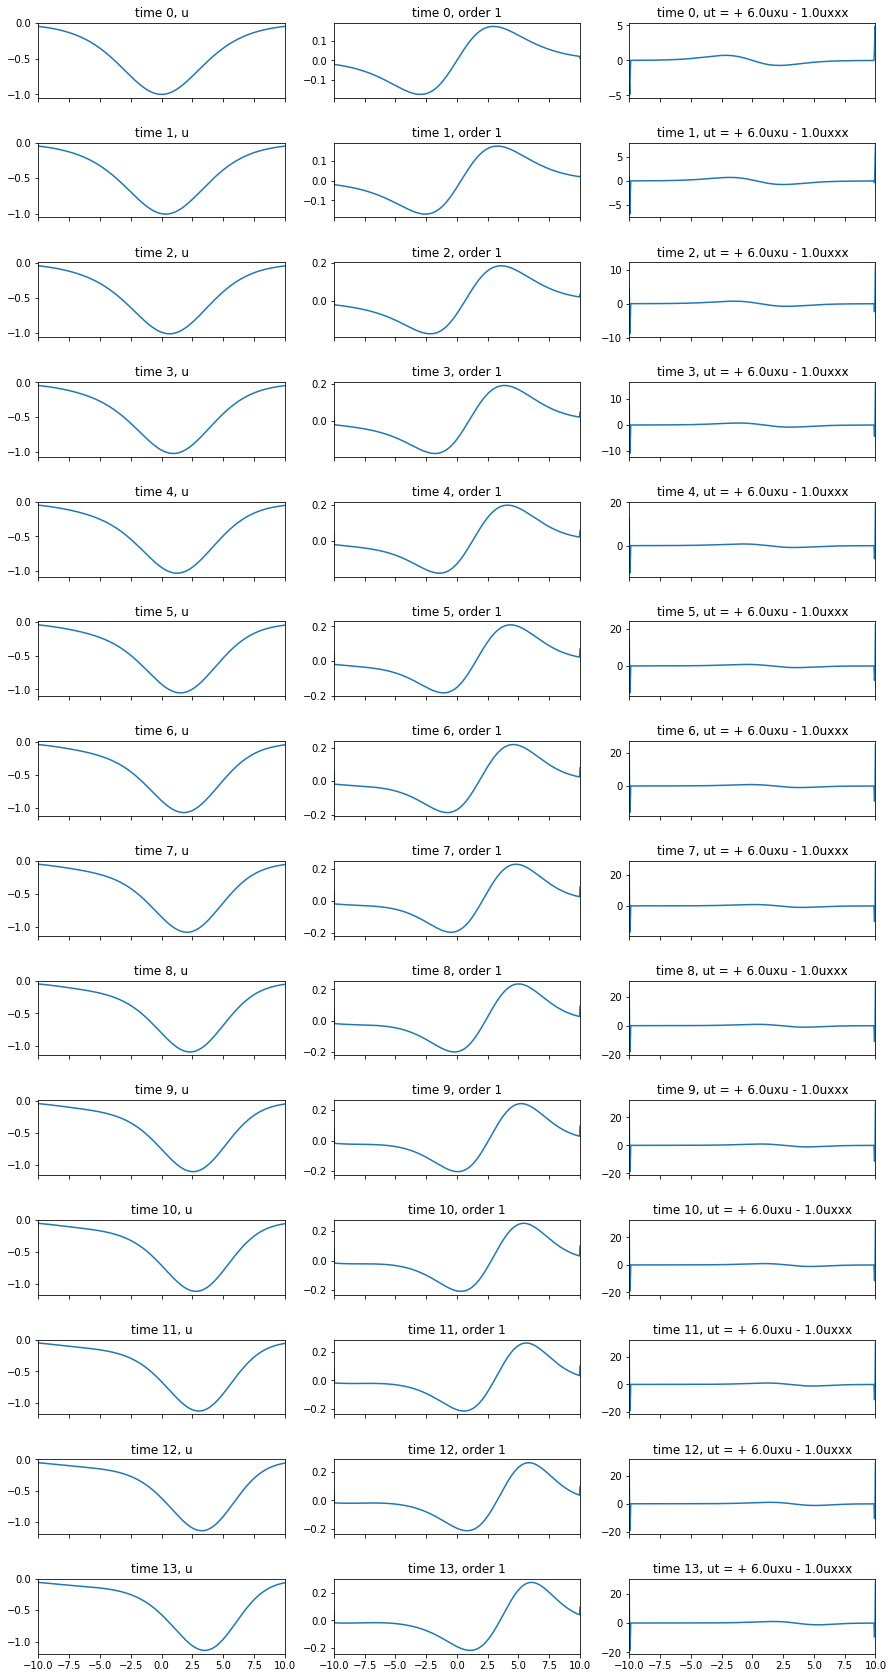

In [26]:
max_time = 14
lim_disc = 0
plot_order = 1
jump_fact = 1

fig, axes = plt.subplots(nrows=max_time//jump_fact, ncols=plot_order+2, figsize=(15,30), sharex='all', sharey='none')
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    #plot
    if time%jump_fact == 0: 
        #function
        yu = list(pde.u[time])
        axes[time//jump_fact, 0].plot(x, yu)
        axes[time//jump_fact, 0].set(title='time '+str(time)+', u')
        #xderivs
        for order in range(1, plot_order+1):
            yx = [pde.get_x_deriv(time, point, order) for point in range(pde.xpoints)]
            axes[time//jump_fact, order].plot(x, yx)
            axes[time//jump_fact, order].set(title='time '+str(time)+', order '+str(order))
        #tderiv
        yt = [pde.get_t_deriv(time, point) for point in range(pde.xpoints)]
        axes[time//jump_fact, -1].plot(x, yt)
        axes[time//jump_fact, -1].set(title='time '+str(time)+', '+str(pde))
        #scaling
        #ymin = np.min(y[int(pde.xpoints*lim_disc):int(pde.xpoints*(1-lim_disc))])
        #ymax = np.max(y[int(pde.xpoints*lim_disc):int(pde.xpoints*(1-lim_disc))])
        axes[time//jump_fact, 0].set_xlim(pde.xrange[0], pde.xrange[1])
        #axes[time//jump_fact, 0].set_ylim(ymin, ymax)
    
    #simulating
    pde.u[time+1] = pde.sim_next_grid(time)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

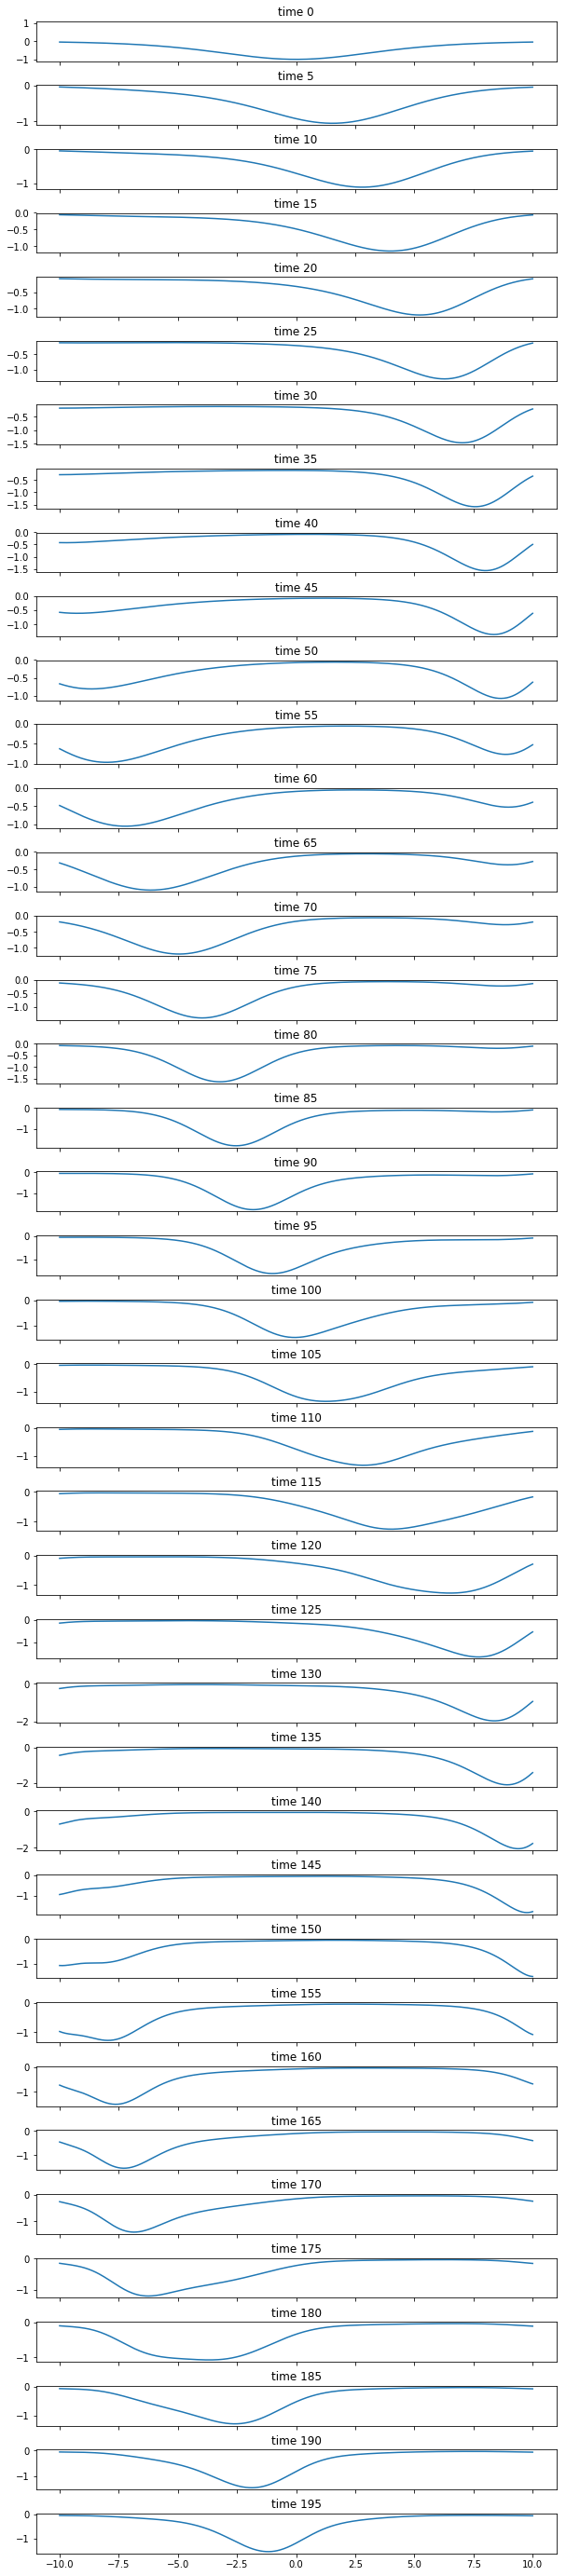

In [27]:
np.seterr(all='raise')
np.seterr(under='ignore')

max_time = pde.tpoints-1
jump_fact = 5

fig, axes = plt.subplots(nrows=max_time//jump_fact, figsize=(10,50), sharex=True, sharey=False)
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    #print(str(time)+": u = "+str(pde.u[time, 0]))
    if time % jump_fact == 0:
        y = pde.u[time]
        axes[time//jump_fact].plot(x, y)
        axes[time//jump_fact].set(title='time '+str(time))
    pde.u[time+1] = pde.sim_next_grid(time)
axes[0].set_ylim(-1.1, 1.1)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

In [61]:
class PDE_FIND:
    def __init__(self, max_order, max_degree, twidth):
        self.max_order=max_order
        self.max_degree=max_degree
        self.twidth = twidth
    
    def get_t_deriv_grid(self, u, point, trange, deg=10, twidth=5):
        tpoints = u.shape[0]
        #deg controls the degree of the fitted polynomial
        deriv = np.empty((tpoints-2*twidth,))
        if self.max_order > 0:
            #smoothing
            #creating array of x values
            rangesize = trange[1]-trange[0]
            tarr = np.linspace(trange[0], trange[1], tpoints, endpoint=True)[twidth:-twidth]
            #creating array of u values
            uarr = u[twidth:-twidth, point]
            #fitting polynomial
            poly = np.polynomial.polynomial.Polynomial.fit(tarr, uarr, deg)
            deriv = poly.deriv(1)(tarr)
        return deriv
    def build_ut(self, u, trange, deg=10, twidth=5):
        xpoints = u.shape[1]
        tpoints = u.shape[0]-2*twidth
        matrix = np.empty((xpoints, tpoints))
        for x in range(xpoints):
            matrix[x] = self.get_t_deriv_grid(u, x, trange=trange, deg=deg, twidth=twidth)
        arr = matrix.T.flatten()
        return arr
    
    def get_x_derivs_spacegrid(self, u, time, xrange, deg=10, extra_fact=0.5):
        #deg controls the degree of the fitted polynomial
        #extra_fact controls how much to look ahead and behind the defined interval, since the interval is periodic
        #extra should not be more than half, 
        #    as that would make the fit take into account more than twice the number of points necessary
        xpoints = u.shape[1]
        
        assert extra_fact <= 0.5, "Extra should not be more than half the number of points"
        extra = int(xpoints*extra_fact)
        derivs = np.empty((self.max_order+1, xpoints))
        if self.max_order < 0:
            raise ValueError("Derivative order cannot be negative")
        else:
            derivs[0] = u[time]
            if self.max_order > 0:
                #smoothing
                #creating array of x values
                rangesize = xrange[1]-xrange[0]
                limleft = xrange[0]-rangesize
                limright = xrange[1]+rangesize
                xarrleft = np.linspace(limleft, xrange[0], xpoints, endpoint=False)
                xarrmid = np.linspace(xrange[0], xrange[1], xpoints, endpoint=False)
                xarrright = np.linspace(xrange[1], limright, xpoints, endpoint=False)
                xarr = np.hstack([xarrleft[-extra:], xarrmid, xarrright[:extra]])
                #creating array of u values
                uarr = np.hstack([u[time, -extra:], u[time], u[time, :extra]])
                #fitting polynomial
                poly = np.polynomial.polynomial.Polynomial.fit(xarr, uarr, deg)
                for order in range(1, self.max_order+1):
                    deriv = poly.deriv(order)
                    derivs[order] = deriv(xarrmid)
        return derivs
    def get_x_derivs_fullgrid(self, u, xrange, deg=10, extra_fact=0.5, twidth=5):
        tpoints = u.shape[0]-2*twidth
        xpoints = u.shape[1]
        
        derivs = np.empty((self.max_order+1, tpoints, xpoints))
        for t in range(0, tpoints):
            derivs[:, t, :] = self.get_x_derivs_spacegrid(u, t+twidth, xrange, deg=deg, extra_fact=extra_fact)
        return derivs
    def build_theta(self, u, xrange, deg=10, extra_fact=0.5, twidth=5):
        tpoints = u.shape[0]-2*twidth
        xpoints = u.shape[1]
        
        theta = np.empty((tpoints*xpoints, (self.max_order+1)*(self.max_degree+1)))
        derivs = self.get_x_derivs_fullgrid(u, xrange, deg=deg, extra_fact=extra_fact, twidth=twidth)
        for time in range(tpoints):
            for degree in range(0, self.max_degree+1):
                u_deg_vect = derivs[0, time]**degree
                for order in range(0, self.max_order+1):
                    if order == 0: u_deriv_vect = np.ones_like(derivs[order, time])
                    else: uderiv_vect = derivs[order, time]
                    theta[xpoints*time: xpoints*(time+1), (self.max_degree+1)*order+degree] = u_deg_vect*u_deriv_vect
        return theta
    
    def stridge_identify_terms(self, theta, ut, alpha, tol, iters=10):
        scaler = StandardScaler()
        theta_scaled = scaler.fit_transform(theta)
        ridger = Ridge(alpha, fit_intercept=False, random_state=0)
        ridger.fit(theta_scaled, ut)
        xi = ridger.coef_
        big_feat_j = np.where(xi >= tol)[0]
        small_feat_j = np.where(xi < tol)[0]
        #print("iter: "+str(iters))
        #print("removed "+str(len(small_feat_j))+" out of "+str(len(xi)))
        xi[small_feat_j] = 0
        if len(big_feat_j) == len(xi) or len(small_feat_j) == len(xi):
            return xi
        else:
            xi[big_feat_j] = self.stridge(theta_scaled[:, big_feat_j], ut, alpha, tol, iters-1)
        return xi
    def stridge(self, theta, ut, alpha, tol, iters):
        xi = self.stridge_identify_terms(theta, ut, alpha, tol, iters=10)
        big_feat_j = np.where(xi >= tol)[0]
        if len(big_feat_j) != 0:
            ridger = Ridge(alpha, fit_intercept=False, random_state=0)
            ridger.fit(theta[:, big_feat_j], ut)
            xi[big_feat_j] = ridger.coef_
        return xi

    def calc_error(self, theta_test, ut_test, xi, penalty):
        return np.linalg.norm(np.matmul(theta_test, xi) - ut_test, 2) + penalty*np.linalg.norm(xi)

    def train_stridge(self, theta, ut, alpha, dtol, tol_iters=25, str_iters=10):
        #split
        theta_train, theta_test, ut_train, ut_test = train_test_split(
            theta, ut, test_size=0.20, random_state=0)
        #l0 penalty
        penalty = 1e-3 * np.linalg.cond(theta)
        #baseline
        regresser = LinearRegression()
        regresser.fit(theta, ut)
        xi_best = regresser.coef_
        err_best = self.calc_error(theta_test, ut_test, xi_best, penalty)
        #search
        tol = dtol
        for i in range(tol_iters):
            print("checking tol: "+str(tol))
            xi = self.stridge(theta_test, ut_test, alpha, tol, str_iters)
            err = self.calc_error(theta_test, ut_test, xi, penalty)
            print("best err: "+str(err_best))
            print("curr err: "+str(err))
            if err < err_best: 
                err_best = err
                xi_best = xi
                tol += dtol
            else: #change tolerance
                tol = max([0, tol-2*dtol])
                dtol = 2*dtol / (tol_iters - i) #why?
                tol += dtol
        return xi_best

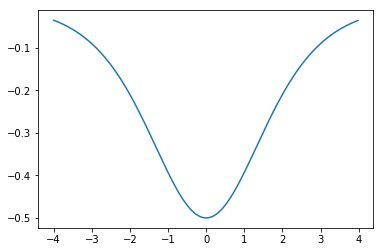

In [62]:
xrange = (-4, 4)
xpoints = 512
trange = (0, 20)
tpoints = 201
xarr = np.linspace(xrange[0], xrange[1], xpoints, endpoint=False)
tarr = np.linspace(trange[0], trange[1], tpoints, endpoint=True)
tt, xx = mesh = np.meshgrid(tarr, xarr)
c = 1
a = 0
t = 0
u = -0.5*c*1/np.cosh( 0.5*np.sqrt(c)*(xx-c*tt-a) )**2
u = u.T
plt.plot(xarr, u[0])

In [63]:
finder = PDE_FIND(max_order=3, max_degree=2, twidth=5)
theta = finder.build_theta(u, xrange)
ut = finder.build_ut(u, trange)
xi = finder.train_stridge(theta, ut, alpha=1e-5, dtol=1)
print(pde.xi.flatten())
print(xi)

checking tol: 1
best err: 2.11215674888e+42
curr err: 7.85827665263
checking tol: 2
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 0.08333333333333333
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 0.007246376811594202
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 0.0006587615283267456
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 6.273919317397578e-05
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 6.2739193173975785e-06
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 6.604125597260609e-07
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 7.337917330289565e-08
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 8.632843917987724e-09
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 1.0791054897484655e-09
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 1.4388073196646207e-10
best err: 7.85827665263
curr err: 7.85827665263
checking tol: 2.055439028092

In [61]:
finder = PDE_FIND(max_order=3, max_degree=2, twidth=5)
theta = finder.build_theta(pde.u, pde.xrange)
ut = finder.build_ut(pde.u, pde.trange)
xi = finder.train_stridge(theta, ut, alpha=1e-5, dtol=1)
print(pde.xi.flatten())
print(xi)

checking tol: 1
best err: 4.69085395618e+40
curr err: 54.2696974581
checking tol: 2
best err: 54.2696974581
curr err: 54.2696974581
checking tol: 0.08333333333333333
best err: 54.2696974581
curr err: 54.2696974581
checking tol: 0.007246376811594202
best err: 54.2696974581
curr err: 54.2696974581
checking tol: 0.0006587615283267456
best err: 54.2696974581
curr err: 54.2696974581
checking tol: 6.273919317397578e-05
best err: 54.2696974581
curr err: 8.058518144e+26
checking tol: 6.2739193173975785e-06
best err: 54.2696974581
curr err: 2.14584611528e+27
checking tol: 6.604125597260609e-07
best err: 54.2696974581
curr err: 2.14584611528e+27
checking tol: 7.337917330289565e-08
best err: 54.2696974581
curr err: 2.14584611528e+27
checking tol: 8.632843917987724e-09
best err: 54.2696974581
curr err: 2.14584611528e+27
checking tol: 1.0791054897484655e-09
best err: 54.2696974581
curr err: 2.14584611528e+27
checking tol: 1.4388073196646207e-10
best err: 54.2696974581
curr err: 2.14584611528e+27
ch

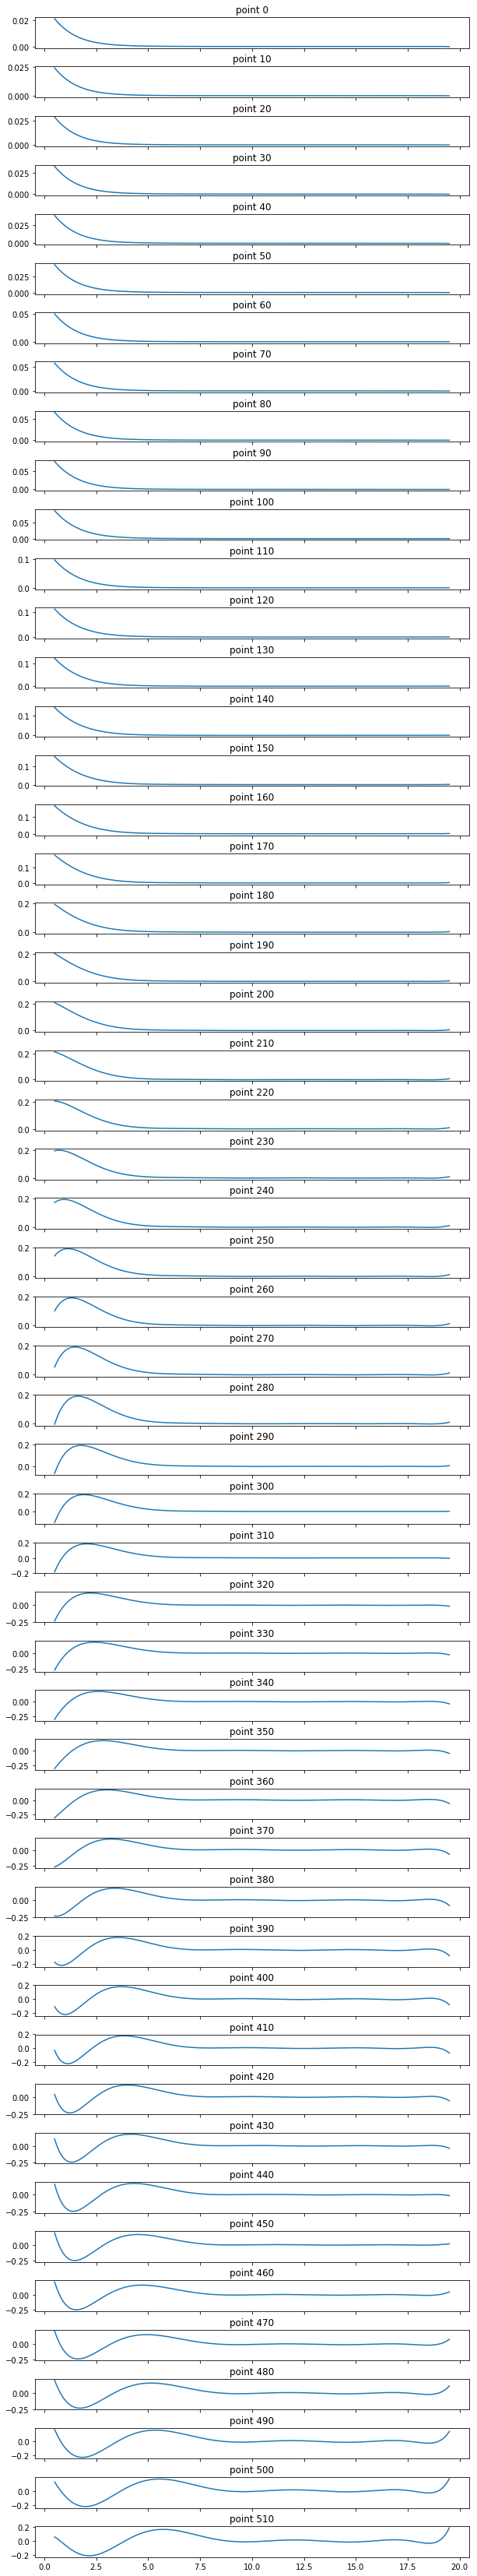

In [67]:
np.seterr(all='raise')
np.seterr(under='ignore')

max_point = xpoints
jump_fact = 10
twidth=5

fig, axes = plt.subplots(nrows=max_point//jump_fact+1, figsize=(10,60), sharex=True, sharey=False)
t = np.linspace(pde.trange[0], pde.trange[1], pde.tpoints)[twidth:-twidth]

for point in range(max_point):
    #print(str(time)+": u = "+str(pde.u[time, 0]))
    if point % jump_fact == 0:
        y = finder.get_t_deriv_grid(u, point, trange, deg=10, twidth=twidth)
        axes[point//jump_fact].plot(t, y)
        axes[point//jump_fact].set(title='point '+str(point))
    
plt.subplots_adjust(hspace=0.6)
plt.show()

### To Do
- make derivative functions be grid based instead of point based, and remove unnecessary deriv functions
- rewrite get_x_deriv and it's forward/backward/middle versions to have less nested steps
- expand possible equations to include more non-linearity, like ut = sin(ux)
- make it possible to have an irregular grid spacing
- add other boundary conditions
- check why harmonic oscillator doesn't conserve energy

### Notes
- Polynomial smoothing does not need to discard endpoints due to the periodic boundary conditions